In [5]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("data[1].csv", encoding='ISO-8859-1')


df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [9]:
df = df.dropna(subset=['CustomerID'])


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [11]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [12]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [13]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [14]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])


In [15]:
rfm['RFM_Score'] = rfm['R_score'].astype(str) + \
                   rfm['F_score'].astype(str) + \
                   rfm['M_score'].astype(str)


In [16]:
def segment(row):
    if row['R_score'] == 5 and row['F_score'] >= 4:
        return 'Champions'
    elif row['F_score'] >= 4:
        return 'Loyal Customers'
    elif row['R_score'] <= 2:
        return 'At Risk'
    else:
        return 'Regular Customers'

rfm['Segment'] = rfm.apply(segment, axis=1)


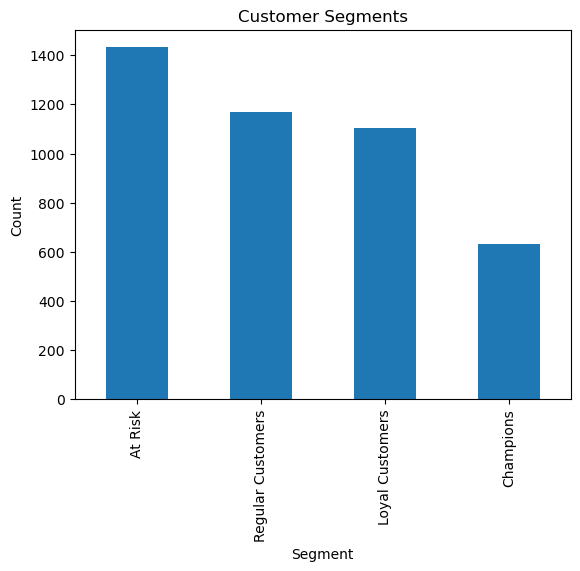

In [17]:
import matplotlib.pyplot as plt

rfm['Segment'].value_counts().plot(kind='bar')
plt.title("Customer Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()


In [18]:
rfm.to_csv("rfm_segments.csv")
